In [28]:
import geopandas as gpd
import libpysal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from epitools import get_data

In [29]:
method = "nv"

In [30]:
gdf_de = gpd.read_file("https://raw.githubusercontent.com/okfde/wahldaten/master/geometrien/wahlkreise/wahlkreise.geojson")

gdf_de = gdf_de.rename(columns={"WKR_NR": "constituency"})

data_de = get_data(
    country="Germany",
    year=2021,
    aggregation="constituency",
    election="first_round",
    method="nv"
)


data_de = pd.merge(data_de, gdf_de, on="constituency")
data_de["country"] = "DE"
data_de["geography_id"] = data_de["constituency"].copy()

data_de = gpd.GeoDataFrame(data_de)


In [31]:
# gdf_de = gpd.read_file("https://gist.githubusercontent.com/nroi/c46b89be647fb896a5302db133f25834/raw/5472db831f2067bb2ec1d95f2832b82e6f34f5fd/germany-de-nuts-3-regions.geojson")
# gdf_de = gdf_de.rename(columns={"ID_1": "state_id"})
# gdf_de
# geography = "state_id"
# df_de = pd.read_csv(f"data_output/Germany/2021_divisiveness_{geography}_{method}.csv.gz", compression="gzip")
# df_de = df_de.dropna()

# data_de = df_de.groupby([geography]).agg({"value": "mean", "candidate": "nunique"})
# data_de["value"] = data_de["value"] * data_de["candidate"]
# data_de = data_de.reset_index()


# data_de = pd.merge(data_de, gdf_de, on=geography)

# data_de = gpd.GeoDataFrame(data_de)
# data_de.head()

In [32]:
gdf_es = gpd.read_file("https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/spain-provinces.geojson")
gdf_es["province_id"] = gdf_es["cod_prov"].astype(int)
gdf_es = gdf_es[~gdf_es["province_id"].isin([38, 35])]

data_es = get_data(
    country="Spain",
    year=2019,
    aggregation="province_id",
    election="first_round",
    method="nv"
)

# gdf_de = gdf_es.rename(columns={"WKR_NR": "constituency"})

data_es = pd.merge(data_es, gdf_es, on="province_id")
data_es["country"] = "ES"
data_es["geography_id"] = data_es["province_id"].copy()

data_es = gpd.GeoDataFrame(data_es)

# data_es["value"] = NormalizeData(data_es["value"])

In [33]:
geography = "department_id"
gdf_fr = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson")
gdf_fr = gdf_fr.rename(columns={"nom": "department", "code": "department_id"})
gdf_fr["department_id"] = gdf_fr["department_id"].str.zfill(2)

data_fr = get_data(
    country="France",
    year=2022,
    aggregation="department_id",
    election="first_round",
    method="nv"
)

data_fr = pd.merge(data_fr, gdf_fr, on=geography)
data_fr["country"] = "FR"
data_fr["geography_id"] = data_fr["department_id"].copy()

data_fr = gpd.GeoDataFrame(data_fr)

# data_fr["value"] = NormalizeData(data_fr["value"])

In [35]:
gdf_it = gpd.read_file("https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson")
gdf_it = gdf_it.rename(columns={"prov_istat_code": "province_id"})


data_it = get_data(
    country="France",
    year=2022,
    aggregation="province_id",
    election="first_round",
    method="nv"
)

data_it["province_id"] = data_it["province_id"].astype(str).str.zfill(3)
data_it = pd.merge(data_it, gdf_it, on="province_id")
data_it["country"] = "DE"
data_it["geography_id"] = data_it["province_id"].copy()

data_it = gpd.GeoDataFrame(data_it)

# data_it["value"] = NormalizeData(data_it["value"])

In [36]:
data = pd.concat([
    data_es,
    data_fr,
    data_it,
    data_de
])

(-10.692476479954946,
 19.911470079053867,
 34.173646720017544,
 56.052894879631566)

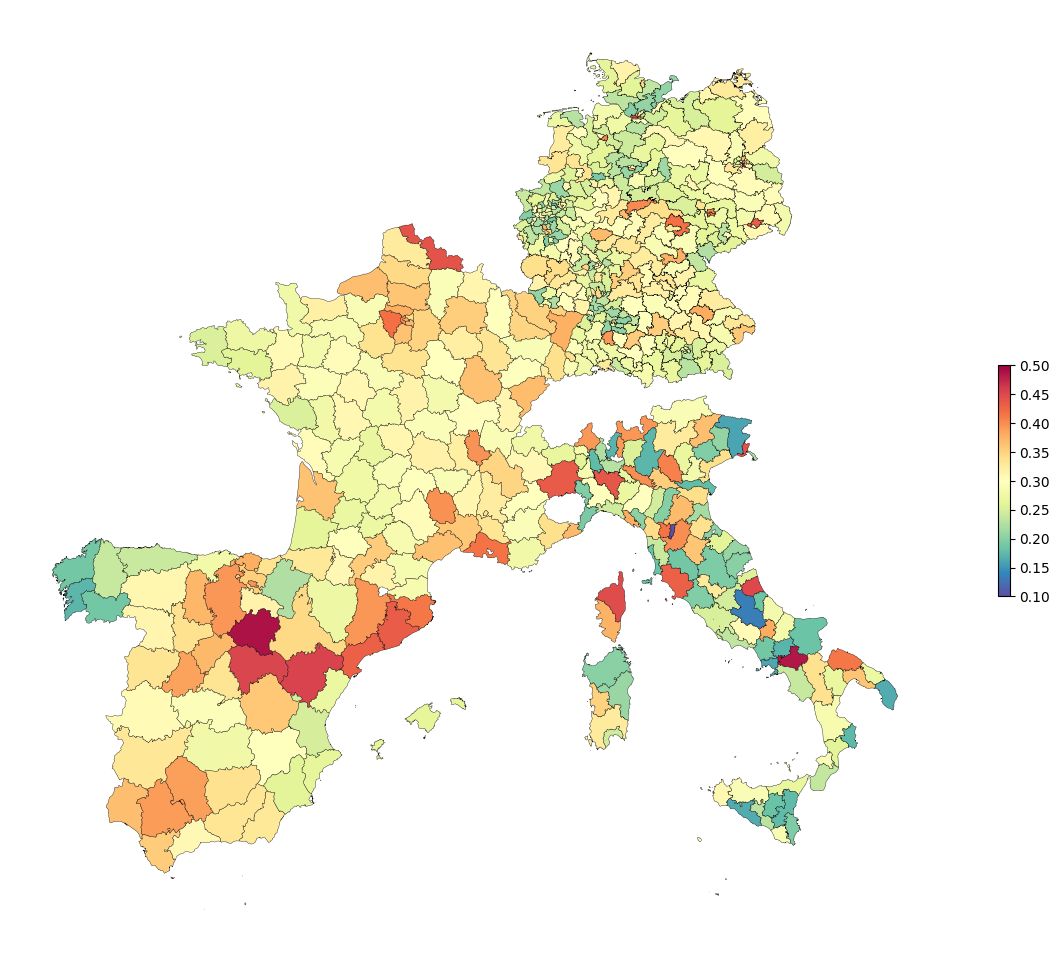

In [37]:
fig, ax = plt.subplots(figsize=(15, 15), dpi=100)

data.plot(
    column="epi", ax=ax, 
    lw=0.25,
    vmin=0.1,
    vmax=0.5,
    legend=True, 
    edgecolor="black",
    cmap="Spectral_r",
    legend_kwds=dict(
        shrink=0.2
    ))

plt.axis("off")

In [48]:
output = []
for idx, row in data.iterrows():
    data_foreign = data[data["country"] != row["country"]]
    neighbors = np.array(data_foreign[data_foreign.geometry.touches(row["geometry"])].geography_id)
    overlap = np.array(data_foreign[data_foreign.geometry.overlaps(row["geometry"])].geography_id)
    neighbors_foreign = list(neighbors) + list(overlap)

    data_local = data[data["country"] == row["country"]]
    neighbors = np.array(data_local[data_local.geometry.touches(row["geometry"])].geography_id)
    overlap = np.array(data_local[data_local.geometry.overlaps(row["geometry"])].geography_id)
    neighbors_local = list(neighbors) + list(overlap)

    neighbors = np.array(data[data.geometry.touches(row["geometry"])].geography_id)
    overlap = np.array(data[data.geometry.overlaps(row["geometry"])].geography_id)
    neighbors_total = list(neighbors) + list(overlap)

    output.append({
        "avg_value_local": data[data["geography_id"].isin(neighbors_local)]["value"].mean(),
        "avg_value_foreign": data[data["geography_id"].isin(neighbors_foreign)]["value"].mean(),
        "avg_value_total": data[data["geography_id"].isin(neighbors_total)]["value"].mean(),
        "geography_id": row["geography_id"],
        "country": row["country"],
        "value": row["value"]
    })

In [49]:
pd.DataFrame(output).to_csv("test_neighbors.csv", index=False)

In [ ]:
import libpysal

# create weights
W = libpysal.weights.Queen.from_dataframe(data)

# row-normalise weights
W.transform = "r"

# create lag
data["averaged_value"] = libpysal.weights.lag_spatial(W, data["value"])

('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 48, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')


C:\Users\cnava\AppData\Roaming\Python\Python310\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 3 islands with ids: 6, 48, 49.
  warnings.warn(message)


In [ ]:
data[["value", "averaged_value"]].to_csv("test.csv", index=False)